In [1]:
from neo4j import GraphDatabase

In [2]:
graph = GraphDatabase.driver("bolt://neo4j:7687", auth=("neo4j", "test"), encrypted=False)

In [3]:
# clear all existing nodes, should use this on a huge database (just delete the graphdb file)
with graph.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

# Create Nodes

In [4]:
def create_person(tx, name, email=None):
    return tx.run("CREATE (a:Person {name:$name, email:$email}) "
                  "RETURN id(a)", name=name, email=email).single().value()

with graph.session() as session:
    # some nodes have extra attributes (e.g. email)
    jp_node_id = session.write_transaction(create_person, "JP", "jean.p.ebejer@um.edu.mt")
    matthew_node_id = session.write_transaction(create_person, "Matthew")
    marc_node_id = session.write_transaction(create_person, "Marc")
    jasmine_node_id = session.write_transaction(create_person, "Jasmine")    

# Create Relationships

In [5]:
# don't use internal Neo4j IDs  as not reccommended

def create_lectures(tx, a_name, b_name):
    return tx.run("MATCH (a:Person {name: $a_name})"
                  "MATCH (b:Person {name: $b_name})"
                  "CREATE (a)-[r:LECTURES]->(b)"
                  "RETURN type(r)", a_name=a_name, b_name=b_name).single().value()

def create_friends_bidirectional(tx, a_name, b_name, expires=None):
    return tx.run("MATCH (a:Person {name: $a_name})"
                  "MATCH (b:Person {name: $b_name})"
                  "CREATE (a)-[r1:FRIENDS { expires: $expires }]->(b)"
                  "CREATE (a)<-[r2:FRIENDS { expires: $expires }]-(b)" # looks silly but create only allows directional
                  "RETURN type(r1)", a_name=a_name, b_name=b_name, expires=expires).single().value()

with graph.session() as session:
    session.write_transaction(create_lectures, "JP", "Matthew")    
    session.write_transaction(create_lectures, "JP", "Jasmine")
    session.write_transaction(create_friends_bidirectional, "Jasmine", "Marc")
    session.write_transaction(create_friends_bidirectional, "Jasmine", "Matthew", "Jan 2019")

You can have a look at the above graph via your web browser http://localhost:7474/browser/.  There is a helpful [Neo4j Cypher cheatsheet](https://neo4j.com/docs/pdf/neo4j-cypher-refcard-stable.pdf).

In [6]:
def get_all_names(tx):
    names = []
    for record in tx.run("MATCH (p:Person) RETURN p.name AS name"):
        print(record['name'])
        names.append(record['name'])
    return names

# Example of the cypher language
with graph.session() as session:
    session.read_transaction(get_all_names)    

JP
Matthew
Marc
Jasmine


In [7]:
  
def match_person_node(tx, name):
    result = tx.run("MATCH (a:Person {name: $name}) RETURN a", name=name)
    return result.single()[0]

with graph.session() as session:
    record = session.read_transaction(match_person_node, "JP")
    print(record['name'], record['email'])
    print(record.keys())
    print(record.values())

JP jean.p.ebejer@um.edu.mt
dict_keys(['name', 'email'])
dict_values(['JP', 'jean.p.ebejer@um.edu.mt'])


In [8]:
with graph.session() as session:
    rels = session.run("MATCH (n)-[r]-(m) RETURN distinct type(r) as r")
    for r in rels:
        print(r['r'])

LECTURES
FRIENDS


In [9]:
with graph.session() as session:
    record = session.run("MATCH (n) return n")
    for r in record:
        print(r['n']['name'])

JP
Matthew
Marc
Jasmine


In [10]:
with graph.session() as session:
    record = session.run("MATCH (a:Person)-[:LECTURES]->(s)"
                         "WHERE a.name = $name "
                         "RETURN s.name as name", name="JP")
    for r in record:
        print(r['name'])

Jasmine
Matthew


In [11]:
# from all of Jasmine friends ...
with graph.session() as session:
    results = session.run('MATCH (Person { name:"Jasmine" })-[:FRIENDS]->(x) RETURN x as jasmine_friend')
    for jf in results:
        print(jf['jasmine_friend']['name'])

Matthew
Marc


In [12]:
# add some more data
with graph.session() as session:
    # some nodes have extra attributes (e.g. email)
    session.write_transaction(create_person, "Caroline")
    session.write_transaction(create_person, "Michael")
    session.write_transaction(create_friends_bidirectional, "Marc", "Caroline")
    session.write_transaction(create_friends_bidirectional, "Caroline", "Michael")
    session.write_transaction(create_friends_bidirectional, "Michael", "Matthew")

In [13]:

# Find all paths from Marc to Matthew
with graph.session() as session:
    results = session.run('MATCH p = ((p1:Person { name:"Marc" })-[r:FRIENDS*1..]->(p2:Person { name:"Matthew" })) '
                          'WHERE ALL(x IN NODES(p) WHERE SINGLE(y IN NODES(p) WHERE y = x))'
                          'RETURN nodes(p) as nodes, LENGTH(p) as length '
                          'ORDER BY length')
    for r in results:
        print(r['nodes'])    
        
    

[<Node id=2 labels=frozenset({'Person'}) properties={'name': 'Marc'}>, <Node id=3 labels=frozenset({'Person'}) properties={'name': 'Jasmine'}>, <Node id=1 labels=frozenset({'Person'}) properties={'name': 'Matthew'}>]
[<Node id=2 labels=frozenset({'Person'}) properties={'name': 'Marc'}>, <Node id=4 labels=frozenset({'Person'}) properties={'name': 'Caroline'}>, <Node id=5 labels=frozenset({'Person'}) properties={'name': 'Michael'}>, <Node id=1 labels=frozenset({'Person'}) properties={'name': 'Matthew'}>]


In [14]:
# Find shortest paths from Marc to Matthew
with graph.session() as session:
    results = session.run('MATCH p = shortestpath((x)-[FRIENDS*1..]->(y)) '
                          'WHERE x.name = "Marc" AND y.name = "Matthew" '
                          'RETURN NODES(p) AS n ')
    for r in results:
        for n in r['n']:
            print(n['name'])

Marc
Jasmine
Matthew


# Visualization (Attempt)

JP
Matthew
Marc
Jasmine
Caroline
Michael


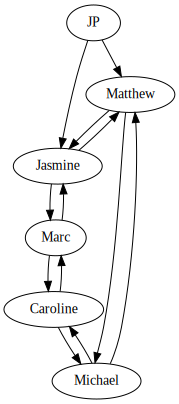

In [15]:
from graphviz import Digraph

dot = Digraph()

with graph.session() as session:
    names = session.read_transaction(get_all_names) 
    for n in names:
        dot.node(n) # add nodes

with graph.session() as session:
    for n in names:
        results = session.run('MATCH (Person { name:$name })-[*1]->(p) RETURN p', name=n)
        for r in results:
            innerName = r['p']['name']
            dot.edge(n, innerName) # add edges

dot

In [16]:
#close the db
graph.close()